(1) Implement sampling and quantization techniques for the given speech signals.

(1a) Plot the original speech signal

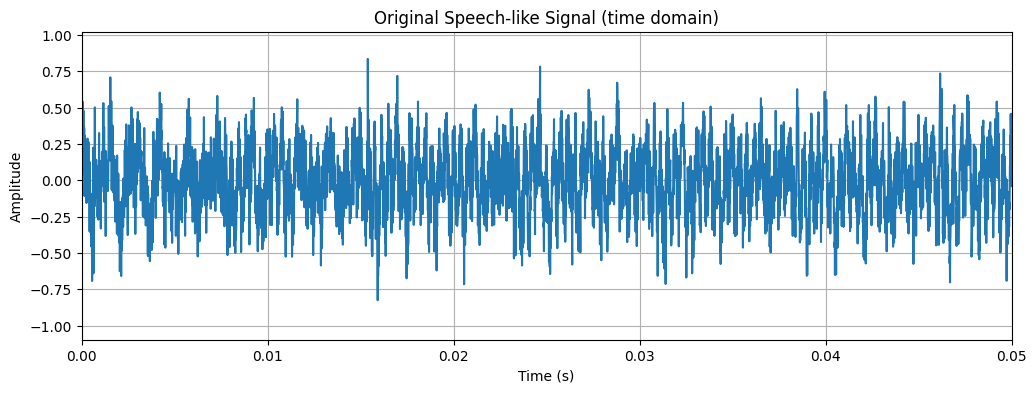

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import iirpeak

# Generate synthetic speech-like signal using source-filter model
fs_orig = 96000  # high reference sampling rate
duration = 1.0
t = np.arange(0, duration, 1/fs_orig)

# Fundamental frequency (voiced pitch)
f0 = 130.0
imp = np.zeros_like(t)
period = int(round(fs_orig / f0))
imp[::period] = 1.0  # impulse train

# Formant resonators (vowel-like sound)
formants = [700, 1220, 2600]
Qs = [30, 60, 80]
gains = [1.0, 0.7, 0.5]

sig = np.zeros_like(t)
for f, Q, g in zip(formants, Qs, gains):
    w0 = f / (fs_orig / 2)
    b, a = iirpeak(w0, Q)
    sig += g * signal.lfilter(b, a, imp)

sig += 0.001 * np.random.randn(len(sig))  # add slight noise
sig = sig / np.max(np.abs(sig))           # normalize

# Plot time-domain representation
plt.figure(figsize=(12, 4))
plt.plot(t, sig)
plt.title("Original Speech-like Signal (time domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim(0, 0.05)  # zoom for detail
plt.grid(True)
plt.show()


(1b) Sampling at 8 kHz, 16 kHz, 44.1 kHz

In [ ]:
# Define target sampling rates
target_fs_list = [8000, 16000, 44100]
sampled_signals = {}

for fs_target in target_fs_list:
    t_samp = np.arange(0, duration, 1/fs_target)
    idx = np.round(t_samp * fs_orig).astype(int)
    idx = np.clip(idx, 0, len(sig)-1)
    sampled = sig[idx]
    sampled_signals[fs_target] = (t_samp, sampled)

print("✅ Sampling completed at 8 kHz, 16 kHz, 44.1 kHz.")


✅ Sampling completed at 8 kHz, 16 kHz, 44.1 kHz.


(1c) Plot sampled signals

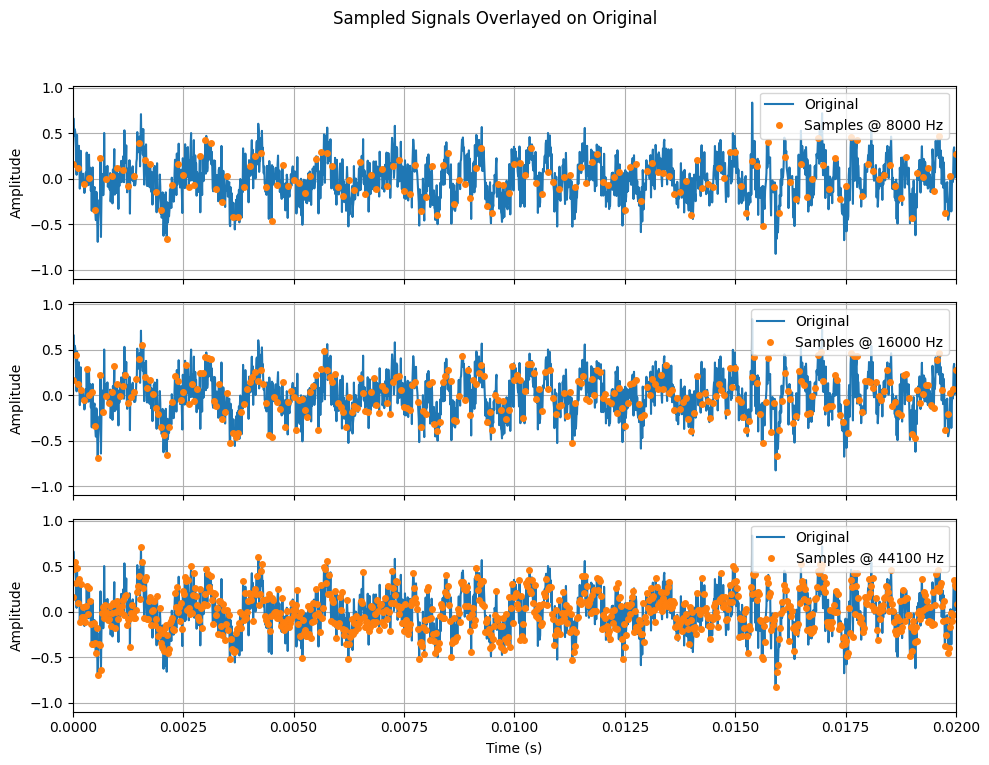

In [ ]:
fig, axs = plt.subplots(len(target_fs_list), 1, figsize=(10, 8), sharex=True)
for ax, fs_target in zip(axs, target_fs_list):
    t_samp, sampled = sampled_signals[fs_target]
    ax.plot(t, sig, label="Original")
    ax.plot(t_samp, sampled, 'o', markersize=4, label=f"Samples @ {fs_target} Hz")
    ax.set_xlim(0, 0.02)  # zoom
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")
    ax.grid(True)
axs[-1].set_xlabel("Time (s)")
plt.suptitle("Sampled Signals Overlayed on Original")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


(1d) Reconstruction (ZOH vs Linear)

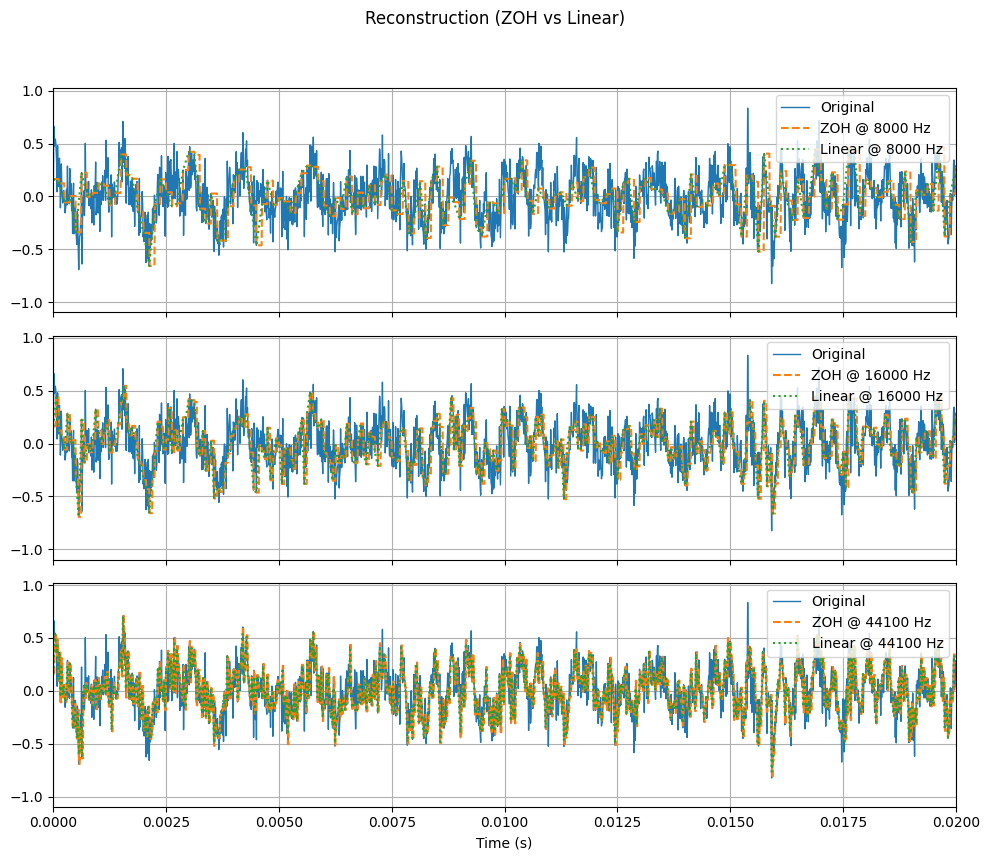

In [ ]:
results = {}

for fs_target in target_fs_list:
    t_samp, sampled = sampled_signals[fs_target]

    # Zero-Order Hold reconstruction
    sample_index = np.floor(t * fs_target).astype(int)
    sample_index = np.clip(sample_index, 0, len(sampled)-1)
    recon_zoh = sampled[sample_index]

    # Linear interpolation reconstruction
    recon_lin = np.interp(t, t_samp, sampled)

    results[fs_target] = (recon_zoh, recon_lin)

# Plot reconstructions
fig, axs = plt.subplots(len(target_fs_list), 1, figsize=(10, 9), sharex=True)
for ax, fs_target in zip(axs, target_fs_list):
    recon_zoh, recon_lin = results[fs_target]
    ax.plot(t, sig, label="Original", linewidth=1)
    ax.plot(t, recon_zoh, '--', label=f"ZOH @ {fs_target} Hz")
    ax.plot(t, recon_lin, ':', label=f"Linear @ {fs_target} Hz")
    ax.set_xlim(0, 0.02)  # zoom
    ax.legend(loc="upper right")
    ax.grid(True)
axs[-1].set_xlabel("Time (s)")
plt.suptitle("Reconstruction (ZOH vs Linear)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


(1e) Mean Squared Error (MSE)

In [ ]:
for fs_target in target_fs_list:
    recon_zoh, recon_lin = results[fs_target]
    mse_zoh = np.mean((sig - recon_zoh)**2)
    mse_lin = np.mean((sig - recon_lin)**2)
    print(f"fs={fs_target} Hz → MSE ZOH={mse_zoh:.6f}, MSE Linear={mse_lin:.6f}")


fs=8000 Hz → MSE ZOH=0.067793, MSE Linear=0.037579
fs=16000 Hz → MSE ZOH=0.047139, MSE Linear=0.031327
fs=44100 Hz → MSE ZOH=0.036802, MSE Linear=0.019732


Sampling and reconstruction:

**Sampling:**

*   The plots in step (1c) visually demonstrate the effect of different sampling rates. As the sampling rate decreases, the sampled points become sparser, potentially losing information about the original signal's shape.
*   The MSE results in step (1e) show that lower sampling rates generally lead to higher reconstruction error (both for ZOH and Linear interpolation). This is expected because there are fewer samples to represent the original signal.

**Reconstruction (ZOH vs. Linear):**

*   The reconstruction plots in step (1d) show that Linear interpolation generally provides a smoother reconstruction that more closely resembles the original signal compared to Zero-Order Hold (ZOH). ZOH creates a stepped output, holding the value of the last sampled point until the next sample.
*   The MSE results in step (1e) quantitatively confirm this observation. For all tested sampling rates, the Mean Squared Error for Linear interpolation is significantly lower than for Zero-Order Hold. This indicates that Linear interpolation is a better reconstruction method in terms of minimizing the difference between the original and reconstructed signals.

**Overall:**

*   Higher sampling rates lead to better reconstruction quality (lower MSE) for both methods.
*   Linear interpolation consistently outperforms Zero-Order Hold for reconstructing the signal from its samples.

(2) Implement the source-filter model for a given speech signal and analyze the impact of sampling and reconstruction on the quality of the speech signal.

(2a) Generate a synthetic speech signal using the source-filter model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, iirpeak

# Parameters
fs_orig = 96000  # high reference sampling rate
duration = 1.0
t = np.arange(0, duration, 1/fs_orig)

# Source (voiced) = glottal pulse train
f0 = 120.0  # pitch frequency (Hz)
imp = np.zeros_like(t)
period = int(round(fs_orig / f0))
imp[::period] = 1.0  # impulses at pitch period

# Source (unvoiced) = white noise
noise = np.random.randn(len(t)) * 0.1

# Choose voiced source for now
source = imp

# Vocal tract filter (formants for vowel-like sound /a/)
formants = [700, 1220, 2600]  # Hz
Qs = [30, 60, 80]
gains = [1.0, 0.7, 0.5]

speech = np.zeros_like(source)
for f, Q, g in zip(formants, Qs, gains):
    w0 = f / (fs_orig / 2)
    b, a = iirpeak(w0, Q)
    speech += g * lfilter(b, a, source)

# Normalize
speech = speech / np.max(np.abs(speech))

print("✅ Synthetic speech generated using source-filter model")


✅ Synthetic speech generated using source-filter model


(2b) Plot the generated speech signal and effect of filter

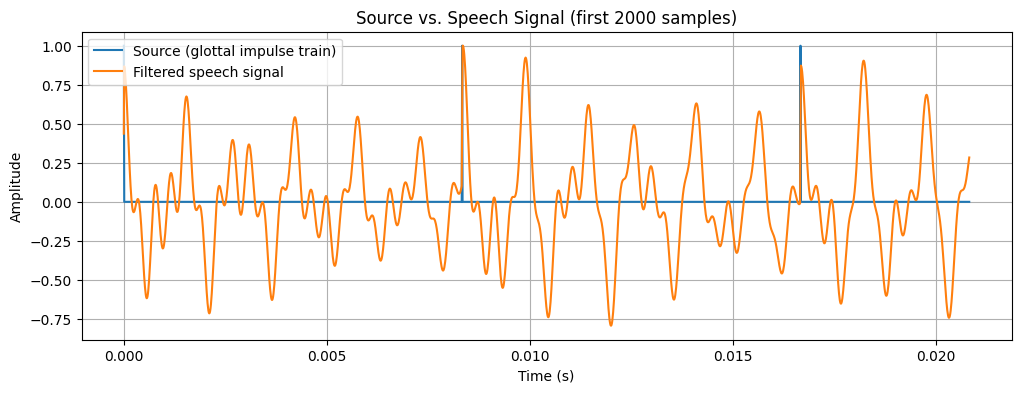

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(t[:2000], source[:2000], label="Source (glottal impulse train)")
plt.plot(t[:2000], speech[:2000], label="Filtered speech signal")
plt.title("Source vs. Speech Signal (first 2000 samples)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


(2c) Sample the speech signal at 8 kHz, 16 kHz, 44.1 kHz

In [ ]:
target_fs_list = [8000, 16000, 44100]
sampled_signals = {}

for fs_target in target_fs_list:
    t_samp = np.arange(0, duration, 1/fs_target)
    idx = np.round(t_samp * fs_orig).astype(int)
    idx = np.clip(idx, 0, len(speech)-1)
    sampled = speech[idx]
    sampled_signals[fs_target] = (t_samp, sampled)

print("✅ Speech signal sampled at 8kHz, 16kHz, 44.1kHz")


✅ Speech signal sampled at 8kHz, 16kHz, 44.1kHz


(2d) Reconstruct the signal (ZOH & Linear)

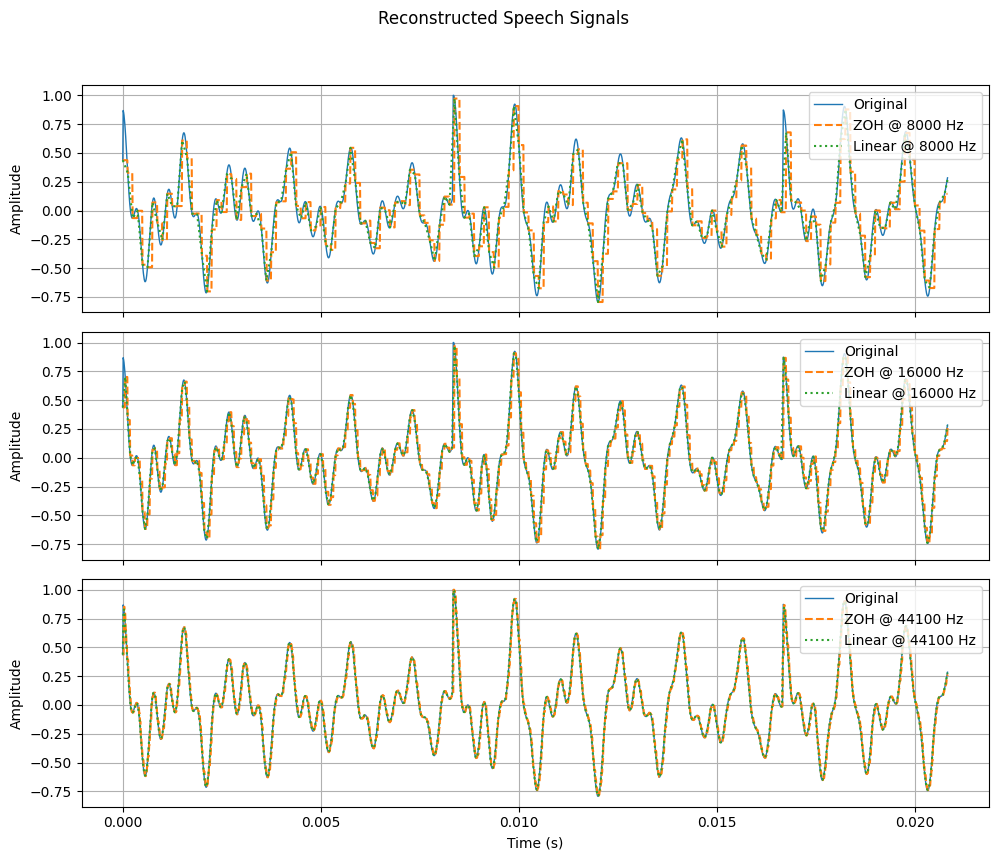

In [ ]:
results = {}

for fs_target in target_fs_list:
    t_samp, sampled = sampled_signals[fs_target]

    # Zero-order hold (nearest neighbor)
    sample_index = np.floor(t * fs_target).astype(int)
    sample_index = np.clip(sample_index, 0, len(sampled)-1)
    recon_zoh = sampled[sample_index]

    # Linear interpolation
    recon_lin = np.interp(t, t_samp, sampled)

    results[fs_target] = (recon_zoh, recon_lin)

# Plot reconstructions
fig, axs = plt.subplots(len(target_fs_list), 1, figsize=(10, 9), sharex=True)
for ax, fs_target in zip(axs, target_fs_list):
    recon_zoh, recon_lin = results[fs_target]
    ax.plot(t[:2000], speech[:2000], label="Original", linewidth=1)
    ax.plot(t[:2000], recon_zoh[:2000], '--', label=f"ZOH @ {fs_target} Hz")
    ax.plot(t[:2000], recon_lin[:2000], ':', label=f"Linear @ {fs_target} Hz")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")
    ax.grid(True)
axs[-1].set_xlabel("Time (s)")
plt.suptitle("Reconstructed Speech Signals")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


(2e) Compute Mean Squared Error (MSE)

In [ ]:
for fs_target in target_fs_list:
    recon_zoh, recon_lin = results[fs_target]
    mse_zoh = np.mean((speech - recon_zoh)**2)
    mse_lin = np.mean((speech - recon_lin)**2)
    print(f"fs={fs_target} Hz → MSE ZOH={mse_zoh:.6f}, MSE Linear={mse_lin:.6f}")


fs=8000 Hz → MSE ZOH=0.025363, MSE Linear=0.003050
fs=16000 Hz → MSE ZOH=0.007573, MSE Linear=0.000678
fs=44100 Hz → MSE ZOH=0.001788, MSE Linear=0.000107


Source-filter model and analyzing the impact of sampling and reconstruction:

**Source-Filter Model and Signal Generation:**

* The plots in step (2b) show the effect of the vocal tract filter on the source signal (impulse train). The filter shapes the spectrum of the impulse train, resulting in a signal that resembles a voiced speech sound with distinct formants. This visually demonstrates how the source-filter model generates speech by filtering a source excitation.

**Sampling and Reconstruction:**

* Similar to the first part of the notebook, the sampling process (step 2c) reduces the number of data points representing the speech signal. Lower sampling rates result in fewer samples.
* The reconstruction plots (step 2d) again highlight the difference between ZOH and Linear interpolation. Linear interpolation provides a smoother reconstruction that more closely follows the original signal's shape, while ZOH creates a stepped approximation.
* The MSE values (step 2e) quantitatively confirm the visual observations. As the sampling rate increases, the MSE for both reconstruction methods decreases significantly, indicating better reconstruction quality.
* Comparing ZOH and Linear interpolation, Linear interpolation consistently results in a much lower MSE than ZOH at all tested sampling rates. This reinforces that linear interpolation is a more effective method for reconstructing the speech signal from its samples, leading to a higher quality reconstructed signal in terms of minimizing error compared to the original.

**Overall:**

* The source-filter model effectively generates a synthetic speech-like signal.
* Higher sampling rates are crucial for preserving the quality of the speech signal during sampling and reconstruction, as they lead to lower reconstruction errors.
* Linear interpolation is a superior reconstruction technique compared to Zero-Order Hold for speech signals, resulting in significantly lower reconstruction errors.